# Gender Prediction Analysis @Foxintelligence

Create a gender prediction model based on newsletters that a user has suscribed to. It's a supervised learning case study. 

- nl_email : newsletter ID (unique for each newsletter)
- id : user ID
- gender: user gender

## Import Libraries

In [24]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot')

## Import Modelling Libraries

In [36]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

## Import & Preview Data

In [2]:
data = pd.read_csv("dataset_test.csv")

In [3]:
#data.head(10)
data.tail(10)

,nl_email,id,gender
8584524,824773,838442,male
8584525,824929,162416,male
8584526,824996,1081281,male
8584527,825044,464017,male
8584528,825044,566353,male
8584529,825044,1416067,male
8584530,825077,587074,male
8584531,825406,149592,female
8584532,825406,175272,male
8584533,825406,277218,male


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8584534 entries, 0 to 8584533
Data columns (total 3 columns):
nl_email    int64
id          int64
gender      object
dtypes: int64(2), object(1)
memory usage: 196.5+ MB
None


In [5]:
data.describe(include='all')

,nl_email,id,gender
count,8.584534e+06,8.584534e+06,8584534
unique,NaN,NaN,2
top,NaN,NaN,male
freq,NaN,NaN,4865002
mean,4.723107e+05,3.402812e+05,NaN
std,2.483444e+05,3.009962e+05,NaN
min,0.000000e+00,1.000000e+00,NaN
25%,2.608062e+05,1.060490e+05,NaN
50%,5.033195e+05,2.598260e+05,NaN
75%,7.233560e+05,4.896950e+05,NaN


In [6]:
#create a work version of dataset
data_w = data.copy(deep = True)

## Clean Data 

In [7]:
# Look for null values
print(data_w.isnull().sum())

nl_email    0
id          0
gender      0
dtype: int64


##### -->no missing values, data appears to be clean

## Convert Formats

In [8]:
#Code categorical data : gender_code (male is '1' and female is '0'), nl_code and id_code
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
label = LabelEncoder()
data_w['nl_code'] = label.fit_transform(data_w['nl_email'])
data_w['id_code'] = label.fit_transform(data_w['id'])
data_w['gender_code'] = label.fit_transform(data_w['gender'])

#Define target variable and delete categorical column
Target = ['gender_code']
data_w.drop(columns = ['gender', 'nl_email', 'id'])

,nl_code,id_code,gender_code
0,0,23652,1
1,62788,23652,1
2,89982,23652,1
3,159185,23652,1
4,176642,23652,1
5,178646,23652,1
6,29073,23652,1
7,235088,23652,1
8,237356,23652,1
9,251901,23652,1


## Feature Reduction

In [69]:
# Group Newsletters by users
users_by_nl = data_w['id_code'].groupby(data_w['nl_code']).count()

# Sort Descending
users_by_nl.sort_values(ascending=False, inplace=True)

print (users_by_nl.head())
print ('\n')
print ('-'*10)
print ('\n')
print (users_by_nl.tail())
users_by_nl.describe(include='all')

nl_code
728929    81792
577008    74552
593870    73961
110810    70888
159157    68377
Name: id_code, dtype: int64


----------


nl_code
374432    1
653075    1
374434    1
653074    1
825408    1
Name: id_code, dtype: int64


count    825409.00000
mean         10.40034
std         299.58956
min           1.00000
25%           1.00000
50%           1.00000
75%           2.00000
max       81792.00000
Name: id_code, dtype: float64

##### On average, users subscribe to 10 newsletters. We can confidently newsletters that have less than 100 subcribers since we are looking for samples that are statistically representative. For a sample of 800,000 users, with a 5% error and a confidence level of errer of 95%, we are looking at a required sample size of 384.

In [79]:
# Delete newsletters that only have 1 or 2 subscribers
users_by_nl = users_by_nl[users_by_nl >= 400]

users_by_nl.describe(include='all')

count      387.000000
mean      7409.937984
std      11508.967676
min       2002.000000
25%       2526.000000
50%       3578.000000
75%       6334.500000
max      81792.000000
Name: id_code, dtype: float64

In [82]:
users_by_nl

nl_code
728929    81792
577008    74552
593870    73961
110810    70888
159157    68377
593797    58765
176642    58601
685199    56399
526721    51364
773680    50100
110933    49845
349759    45115
337876    44818
370530    43083
372452    36579
773037    32237
723356    29319
767559    27709
535807    27284
771053    25999
496224    25246
440330    23890
824235    22393
669439    22288
131410    21571
545240    20965
796936    20101
773693    19526
54337     18986
183861    18947
          ...  
560544     2160
515799     2154
615787     2148
762910     2145
422843     2138
760942     2135
642234     2131
212067     2130
64540      2127
797293     2125
723160     2123
769655     2123
183865     2109
765778     2107
385302     2104
260964     2097
513977     2087
796315     2080
718276     2066
764412     2065
774070     2061
552956     2060
274577     2053
327783     2048
521663     2047
148358     2039
796227     2021
719715     2019
645805     2003
793311     2002
Name: id_code, L

## Exploratory Analysis 

In [81]:
#Let's look at correlations by gender
#print(data_w['nl_code'].groupby(data_w[Target[0]]).sum())
crosstab_nl = pd.crosstab(data_w['nl_code'],data_w[Target[0]])
crosstab_nl.head()

gender_code,0,1
nl_code,,
0,0,5
1,28,5
2,0,1
3,0,1
4,11,17


In [14]:
# Convert to precentage
#start = time.time()
#for col in range(2):
#    for row in range(crosstab_nl.shape[0]):
#        crosstab_nl[col][row] = (crosstab_nl[col][row] / (crosstab_nl[0][row] + crosstab_nl[1][row])) * 100.
#end = time.time()
#print(end - start)

KeyError: '0'

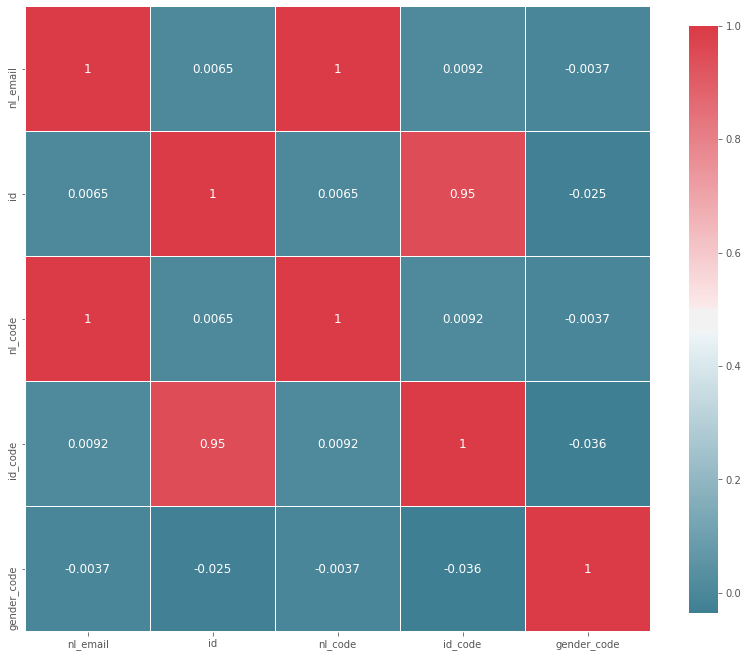

In [32]:
#correlation heatmap
def correlation_heatmap(df):
    """ df.corr Compute pairwise correlation of columns,
    excluding NA/null values."""
    _ , ax = plt.subplots(figsize=(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink':.9},
        ax = ax,
        annot = True, 
        linewidths = 0.1, vmax = 1.0, linecolor = 'white',
        annot_kws = {'fontsize':12}
    )
    
    plt.title =('Pearson Correlation of features')
    
correlation_heatmap(data_w)

##### / ! \ How to interpret this ? Normally, the closest the correlation is to |1|, the most significant the correlation is. However it seems here that some of the data was misinterpreted due to encoding ...  

## Modelling 

##### Knowing we are in a supervised learning context and that the variable we are trying to predict is discrete, we can use a classification algorithm. 

In [56]:
#Algorith selection and initialization (from sklearn)
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #Gaussian Process
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #SVM
    svm.LinearSVC(),
    
    #Tree
    tree.DecisionTreeClassifier(),

    #xgboost
    XGBClassifier()
    ]

# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, \
            test_size = .3, train_size = .6, random_state = 0)
print (cv_split)

# create table to compare models
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', \
               'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare predictions 
MLA_predict = data_w[Target]

# index through models and save performance to table
row_index = 0
for alg in MLA:
    #give names and set parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score models with cross validation
    cv_results = model_selection.cross_validate(alg, data_w['nl_code'], \
            data_w['gender_code'], cv = cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, 
    #should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    #save MLA predictions 
    alg.fit(data_w['nl_code'], data_w[Target])
    MLA_predict[MLA_name] = alg.predict(data_w['nl_code'])
    
    row_index+=1
    
#print and sort table:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

    

ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.6)


/goinfre/miniconda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[212067. 374183. 771932. ... 778365. 825294. 773693.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [46]:
data_w['nl_code'].shape

(8584534,)

In [48]:
data_w['gender_code'].shape

(8584534,)